   *«Я говорил о том, что при определенном уровне цены на нефть новые месторождения вряд ли будут вводиться.»*

   -- Владимир Путин

# Выбор локации для скважины

Добывающая компания «ГлавРосГосНефть» решает, где бурить новую скважину. Для этого предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Извлечём данные и посмотрим на них, начнём с первого региона.

In [2]:
data1 = pd.read_csv('/datasets/geo_data_0.csv')

data1.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [3]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В имеющихся данных отсутсвуют явные пропуски. Из-за характера данных будет затруднительно найти повторы для всех данных, кроме столбца `id`.

In [4]:
len(data1['id'].unique())

99990

In [5]:
data1['id'].value_counts().head(11)

Tdehs    2
HZww2    2
QcMuo    2
bsk9y    2
AGS9W    2
A5aEY    2
fiKDv    2
74z30    2
TtcGQ    2
bxg6G    2
CVa9q    1
Name: id, dtype: int64

Предположим, что повторение повторение `id` скважен связано с тем, что на некоторых из них замеры производились несколько раз. Запишем среднее арифметическое повторяющихся строк в наши данные, а повторы удалим.

In [6]:
for i in data1['id'].value_counts().head(10).index:
    index = data1[data1['id'] == i].index[0]

    data1.loc[index] = data1[data1['id'] == i].mean()
    data1.loc[index, 'id'] = i

data1 = data1.drop_duplicates(subset=['id']).reset_index(drop=True)

В контексте построения модели нам не нужен `id` конкретной скважины. Сохраним их в отдельную пременную и удалим из оригинальных данных.

In [7]:
id1 = data1['id']
data1 = data1.drop(columns='id')

Ряд признаков имеют некоторую корреляцию друг между другом, что может негативно сказаться на качестве обучаемой на этих данных модели.

In [8]:
data1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440724,-0.003184,0.143507
f1,-0.440724,1.000000,0.001792,-0.192333
f2,-0.003184,0.001792,1.000000,0.483645
product,0.143507,-0.192333,0.483645,1.000000


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

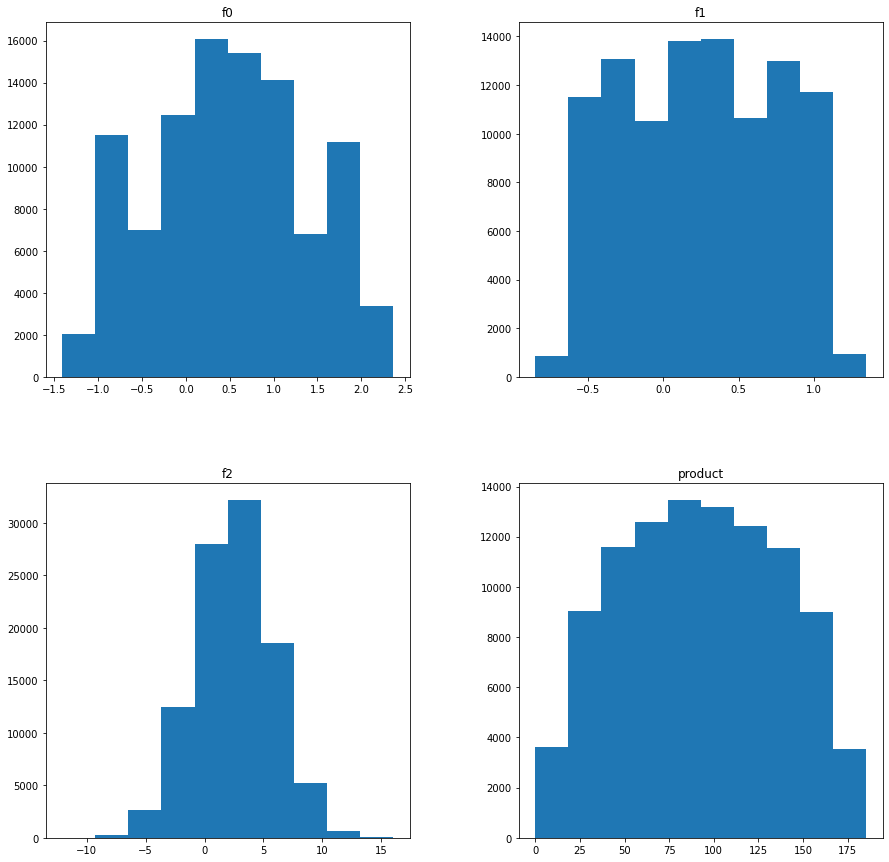

In [9]:
data1.hist(figsize=(15, 15), grid=False)

---

Далее взглянем на данные второго региона.

In [10]:
data2 = pd.read_csv('/datasets/geo_data_1.csv')

data1.head(10)

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647
5,0.969570,0.489775,-0.735383,64.741541
6,0.645075,0.530656,1.780266,49.055285
7,-0.400648,0.808337,-5.624670,72.943292
8,0.643105,-0.551583,2.372141,113.356160
9,2.173381,0.563698,9.441852,127.910945


In [11]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Как и в предыдущем случае в данных отсутсвуют явные пропуски, но имеются повторы индексов.

In [12]:
len(data2['id'].unique())

99996

In [13]:
data2['id'].value_counts().head(11)

LHZR0    2
wt4Uk    2
bfPNe    2
5ltQ6    2
qOYRe    1
n8vHF    1
FiRIG    1
MH1RW    1
sTo8R    1
TNPXf    1
sNuBo    1
Name: id, dtype: int64

Также будем считать, что повторение `id` скважен связано с тем, что на некоторых из них замеры производились несколько раз. Запишем среднее арифметическое повторяющихся строк в наши данные, а повторы удалим.

In [14]:
for i in data2['id'].value_counts().head(4).index:
    index = data2[data2['id'] == i].index[0]

    data2.loc[index] = data2[data2['id'] == i].mean()
    data2.loc[index, 'id'] = i

data2 = data2.drop_duplicates(subset=['id']).reset_index(drop=True)

В контексте построения модели нам не нужен `id` конкретной скважины. Сохраним их в отдельную пременную и удалим из оригинальных данных.

In [15]:
id2 = data2['id']
data2 = data2.drop(columns='id')

Ряд признаков имеют некоторую корреляцию друг между другом, что может негативно сказаться на качестве обучаемой на этих данных модели. Особенно хочется отметить крайне высокую положительную корреляцию между `product` и `f2`.

In [16]:
data2.corr()

,f0,f1,f2,product
f0,1.000000,0.182262,-0.001825,-0.030538
f1,0.182262,1.000000,-0.002609,-0.010168
f2,-0.001825,-0.002609,1.000000,0.999397
product,-0.030538,-0.010168,0.999397,1.000000


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

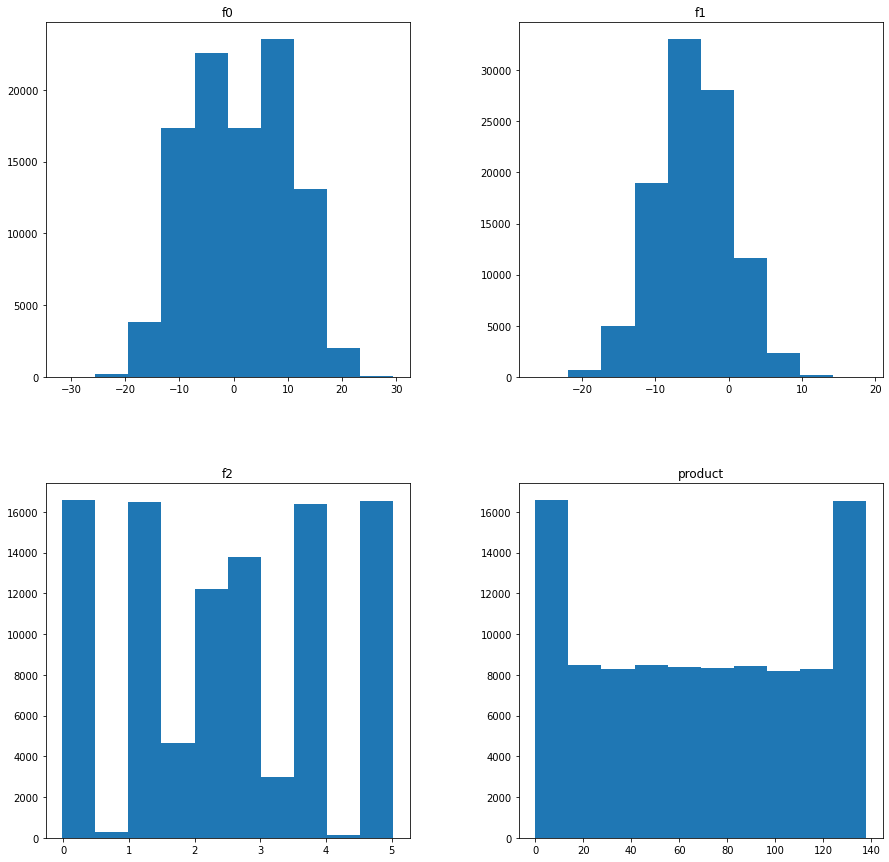

In [17]:
data2.hist(figsize=(15, 15), grid=False)

---

Далее рассмотрим данные из третьей скважины.

In [18]:
data3 = pd.read_csv('/datasets/geo_data_2.csv')

data3.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


In [19]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В данных отсутсвуют явные пропуски, но имеются повторения в признаке `id`.

In [20]:
len(data3['id'].unique())

99996

In [21]:
data3['id'].value_counts().head(11)

xCHr8    2
VF7Jo    2
Vcm5J    2
KUPhW    2
AF8Gm    1
4sfTn    1
OPnHM    1
Vwaek    1
k71HR    1
qdOdr    1
15YSo    1
Name: id, dtype: int64

Исправим пропуски способом, аналогичным ранним способам.

In [22]:
for i in data3['id'].value_counts().head(4).index:
    index = data3[data3['id'] == i].index[0]

    data3.loc[index] = data3[data3['id'] == i].mean()
    data3.loc[index, 'id'] = i

data3 = data3.drop_duplicates(subset=['id']).reset_index(drop=True)

В контексте построения модели нам не нужен `id` конкретной скважины. Сохраним их в отдельную пременную и удалим из оригинальных данных.

In [23]:
id3 = data3['id']
data3 = data3.drop(columns='id')

Эти данные не имеют сильных кореляций друг между другом, если не считать столбцов `product` и `f2`.

In [24]:
data3.corr()

,f0,f1,f2,product
f0,1.000000,0.000504,-0.000451,-0.001969
f1,0.000504,1.000000,0.000765,-0.001049
f2,-0.000451,0.000765,1.000000,0.445863
product,-0.001969,-0.001049,0.445863,1.000000


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

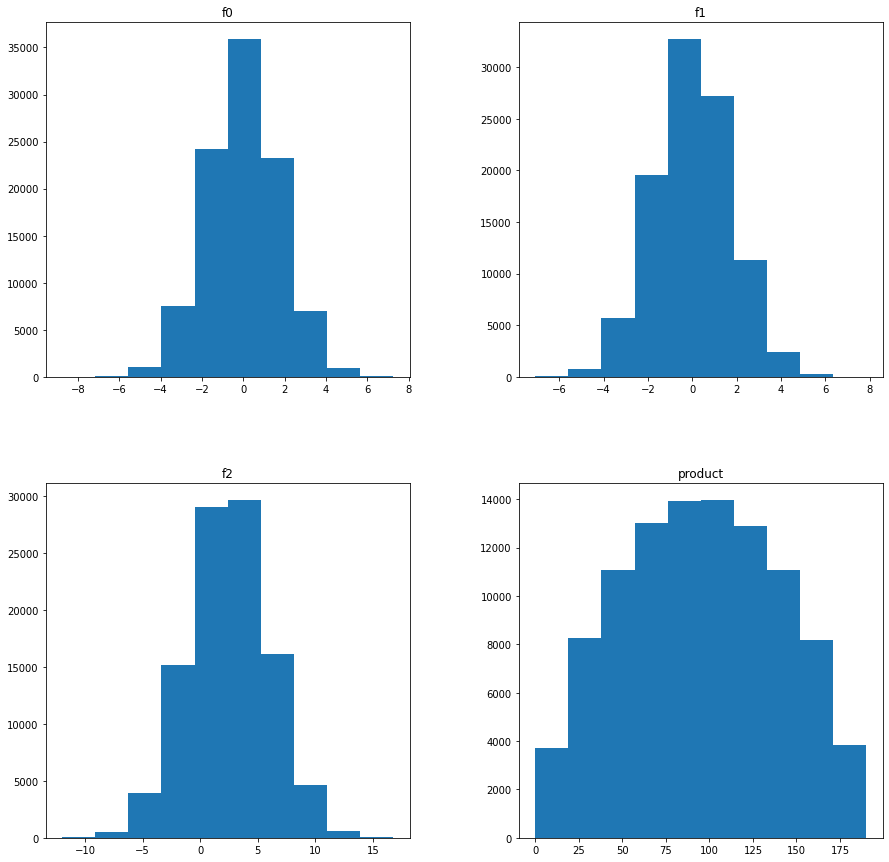

In [25]:
data3.hist(figsize=(15, 15), grid=False)

---

В ходе подготовки данных была проанализирована информация о возможных регионах возведения нефтяных вышек. Объеденена у идулена информация о дублирующихсф идентификаторов скважин. Получено представление о корреляциях признаков в каждом из регионов.

## Обучение и проверка модели

Целевым признаком в нашем исследовании является запас нефти в регионе. Отделим целевые признаки от нецелевых.

In [26]:
# первый регион
f1 = data1.drop(['product'], axis=1)
t1 = data1['product']

# второй регион
f2 = data2.drop(['product'], axis=1)
t2 = data2['product']

# третий регион
f3 = data3.drop(['product'], axis=1)
t3 = data3['product']

Разделим исходные данные на обучающую и валидационную выборки в соотношение 3:1 (75%:25%).

In [27]:
rrrr = 42 # random_state

# разбиение признаков
f1_trn, f1_vld = \
              np.split(f1.sample(frac=1, random_state=rrrr), 
                       [int(.75*len(f1))])
f2_trn, f2_vld = \
              np.split(f2.sample(frac=1, random_state=rrrr), 
                       [int(.75*len(f2))])
f3_trn, f3_vld = \
              np.split(f3.sample(frac=1, random_state=rrrr), 
                       [int(.75*len(f3))])

# разбиение целевого признака
t1_trn, t1_vld = \
              np.split(t1.sample(frac=1, random_state=rrrr), 
                       [int(.75*len(t1))])
t2_trn, t2_vld = \
              np.split(t2.sample(frac=1, random_state=rrrr), 
                       [int(.75*len(t2))])
t3_trn, t3_vld = \
              np.split(t3.sample(frac=1, random_state=rrrr), 
                       [int(.75*len(t3))])

Для обучения моделей восползуемся линейной регрессией. Сделаем предсказания про валидационной выбоке для каждой модели.

In [28]:
m1 = LinearRegression()
m1.fit(f1_trn,t1_trn)
p1_vld = m1.predict(f1_vld) # предсказания по валидационной выборке

m2 = LinearRegression()
m2.fit(f2_trn,t2_trn)
p2_vld = m2.predict(f2_vld) # предсказания по валидационной выборке

m3 = LinearRegression()
m3.fit(f3_trn,t3_trn)
p3_vld = m3.predict(f3_vld) # предсказания по валидационной выборке

Найдём средний запас углеводородов в каждом из регионов и посчитаем погрешность для каждого.

Первый регион: 90 ± 40
Второй регион: 69.1 ± 0.9
Третий регион: 100 ± 40


[Text(0, 0, 'Первый'), Text(1, 0, 'Второй'), Text(2, 0, 'Третий')]

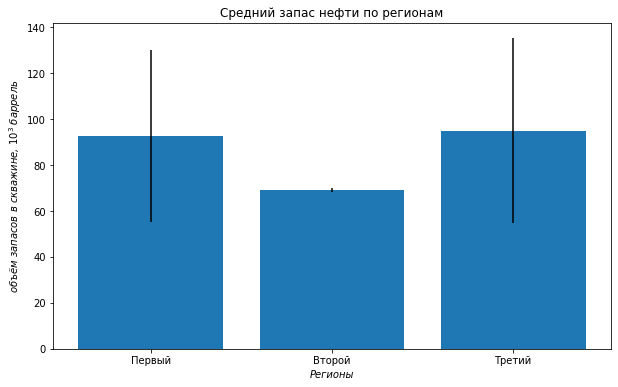

In [29]:
# в соответсвии с правилами округления
print('Первый регион:', round(p1_vld.mean() / 10) * 10, '±', round(mean_squared_error(t1_vld,p1_vld) ** 0.5 / 10) * 10)
print('Второй регион:', round(p2_vld.mean() * 10) / 10, '±', round(mean_squared_error(t2_vld,p2_vld) ** 0.5 * 10) / 10)
print('Третий регион:', round(p3_vld.mean() / 10) * 10, '±', round(mean_squared_error(t3_vld,p3_vld) ** 0.5 / 10) * 10)

means = [p1_vld.mean(), p2_vld.mean(), p3_vld.mean()]
errors = [mean_squared_error(t1_vld,p1_vld) ** 0.5, mean_squared_error(t2_vld,p2_vld) ** 0.5, mean_squared_error(t3_vld,p3_vld) ** 0.5]

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(np.arange(len(means)), means, yerr=errors, align='center', ecolor='black')
ax.set_title('Средний запас нефти по регионам')
ax.set_ylabel('объём запасов в скважине, $10^3$ баррель', style='italic')
ax.set_xlabel('Регионы', style='italic')
ax.set_xticks(np.arange(len(means)))
ax.set_xticklabels(['Первый','Второй','Третий'])

Спрогнозированные средние запасы нефти в первом и третьем регионе одинаковы в пределах погрешности и являются наибольшими из указанных, однако оценка запасов нефти второго региона произведена на два порядка точнее, первого и третьего регионов.

## Подготовка к расчёту прибыли

Найдём объём сырья, необходимый для безубыточной разработки региона.

In [30]:
# разработка региона
stroy = 10 ** 10

# задействованое количество скважин региона
skv = 200

# один баррель нефти
oil_one = 450

stroy_oil = (int(stroy / (oil_one * skv)) + 1)
stroy_oil # баррели

111112

Сравним данный показатель с предсказанными средними запасами нефти в каждом регионе и найдём наиболее вероятную выручку для каждого из них.

Первый регион: 18416675.61525212 ± 7506413.020452151
Второй регион: 13701500.212002972 ± 178518.59848366128
Третий регион: 18892071.694171954 ± 8045947.391013227


[Text(0, 0, 'Первый'), Text(1, 0, 'Второй'), Text(2, 0, 'Третий')]

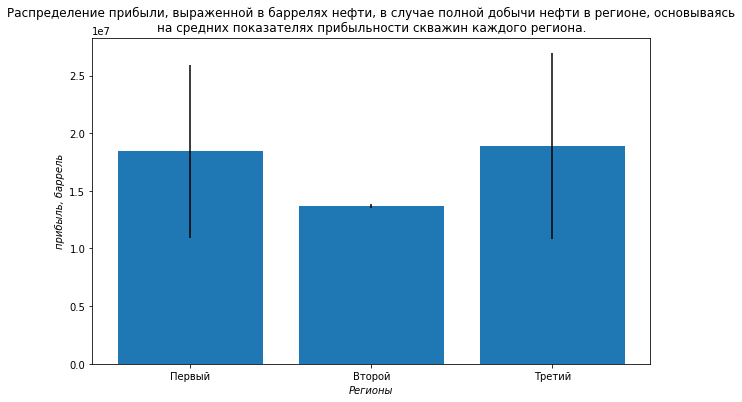

In [31]:
# возвращает доход в баррелях нефти с учётом погрешности
# среднее значение, погрешность
def income_oil(mean,err):
    global stroy_oil, skv
    return skv * mean * 10 ** 3 - stroy_oil, skv * err * 10 ** 3 # вроде правильно погрешность посчитал

# прибыль первого региона
incom1_mean, incom1_err = income_oil(means[0],errors[0])
# прибыль второго региона
incom2_mean, incom2_err = income_oil(means[1],errors[1])
# прибыль третьего региона
incom3_mean, incom3_err = income_oil(means[2],errors[2])


print('Первый регион:', incom1_mean, '±', incom1_err)
print('Второй регион:', incom2_mean, '±', incom2_err)
print('Третий регион:', incom3_mean, '±', incom3_err)

means_i = [incom1_mean, incom2_mean, incom3_mean]
errors_i = [incom1_err, incom2_err, incom3_err]

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(np.arange(len(means_i)), means_i, yerr=errors_i, align='center', ecolor='black')
ax.set_title('Распределение прибыли, выраженной в баррелях нефти, в случае полной добычи нефти в регионе, основываясь\nна средних показателях прибыльности скважин каждого региона.')
ax.set_ylabel('прибыль, баррель', style='italic')
ax.set_xlabel('Регионы', style='italic')
ax.set_xticks(np.arange(len(means_i)))
ax.set_xticklabels(['Первый','Второй','Третий'])

В каждом регионе достаточно нефти для проведения безубыточной добычи при разработки средних по прибыльности скважин. Анализ характера прибыльности региона совпадает со средним запасом нефти по регионам, поскольку, по-сути, это одни и те же рисунки, за исключением того, что на данном графике учтёна стоимость разработки региона, которая является постоянной вне зависимости от региона. 

---

Найдём распределение прибыли в рублях по регионам, в случае, если будут выбраны наиболее выгодные для добычи скважины в каждом из них.

[Text(0, 0, 'Первый'), Text(1, 0, 'Второй'), Text(2, 0, 'Третий')]

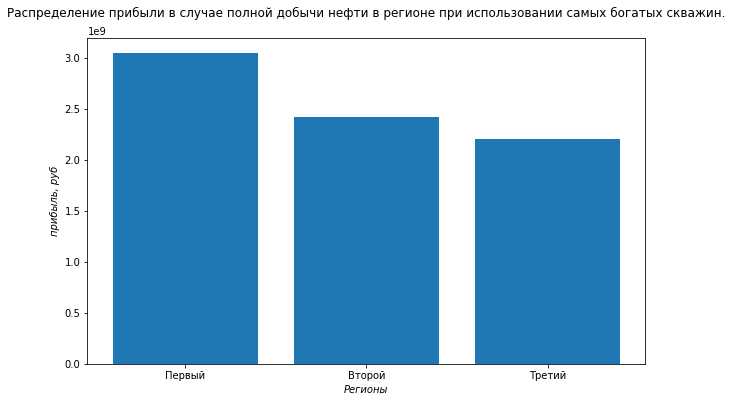

In [32]:
# возвращает количество нефти выработанное богатейшими из выбранных скважин с учётом предсказанных значений
# настоящие значения, предсказанные значения, выбираемое количество скважин
def incom(t,p,skv):
    p = pd.Series(data=p)
    return np.sum(t[p.sort_values(ascending=False).index[:skv]]) * 10 ** 3


# первый регион
d_incom1 = incom(t1_vld.to_numpy(),p1_vld,skv) * oil_one # рубли
# второй регион
d_incom2 = incom(t2_vld.to_numpy(),p2_vld,skv) * oil_one # рубли
# третий регион
d_incom3 = incom(t3_vld.to_numpy(),p3_vld,skv) * oil_one # рубли


doxod = [d_incom1 - stroy, d_incom2 - stroy, d_incom3 - stroy]

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(np.arange(len(doxod)), doxod, align='center')
ax.set_title('Распределение прибыли в случае полной добычи нефти в регионе при использовании самых богатых скважин.\n')
ax.set_ylabel('прибыль, руб', style='italic')
ax.set_xlabel('Регионы', style='italic')
ax.set_xticks(np.arange(len(doxod)))
ax.set_xticklabels(['Первый','Второй','Третий'])

Из рисунка можно видеть, что, в случае разработки наиболее выгодных скважин самым прибыльным оказывается первый регион.

## Расчёт прибыли и рисков 

Применим к имеющимся данным технику Bootstrap, чтобы найти распределение прибыли регионов и составить представление о рисках.

Первый регион:
 - Средннее: 454213603.98156834 руб.
 - Вероятность убытка: 3.2 %
Второй регион:
 - Средннее: 473100642.1353928 руб.
 - Вероятность убытка: 0.4 %
Третий регион:
 - Средннее: 364714094.62741405 руб.
 - Вероятность убытка: 8.7 %


[Text(0, 0, 'Первый'), Text(1, 0, 'Второй'), Text(2, 0, 'Третий')]

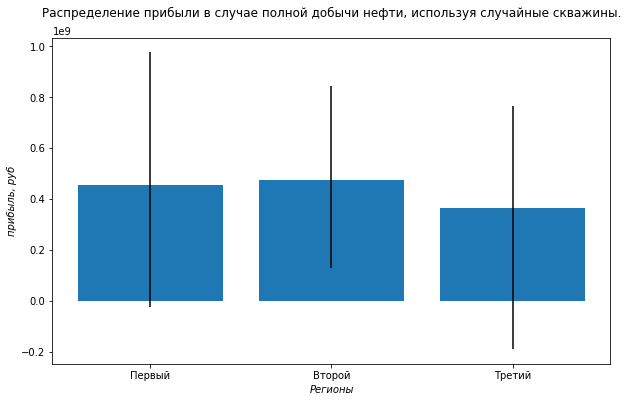

In [33]:
# считает вероятность уйти в убыток при разработки региона
# средние значения прибыли в рублях
def ubiitok(a):
    q = 0.001
    i = a.quantile(q)
    while i < 0:
        i = a.quantile(0.001 + q)
        q = q + 0.001
    return q


# первый регион
incom1 = []
random.seed(rrrr)
for i in range(0,1000):
    index_500 = random.choices(range(0,len(p1_vld)), k=500)
    
    p1_500 = p1_vld[index_500]
    t1_500 = t1_vld.reset_index(drop=True)[index_500].to_numpy()
    
    incom1.append(incom(t1_500,p1_500,skv) * oil_one - stroy) # рубли

incom1 = pd.Series(data=incom1)

mean1 = incom1.mean() 
lower1 = incom1.quantile(0.025)
upper1 = incom1.quantile(0.975)

ubiitok1 = ubiitok(incom1)


# второй регион
incom2 = []
random.seed(rrrr + 1)
for i in range(0,1000):
    index_500 = random.choices(range(0,len(p2_vld)), k=500)
    
    p2_500 = p2_vld[index_500]
    t2_500 = t2_vld.reset_index(drop=True)[index_500].to_numpy()
    
    incom2.append(incom(t2_500,p2_500,skv) * oil_one - stroy) # рубли

incom2 = pd.Series(data=incom2)

mean2 = incom2.mean() 
lower2 = incom2.quantile(0.025)
upper2 = incom2.quantile(0.975)

ubiitok2 = ubiitok(incom2)


# третий регион
incom3 = []
random.seed(rrrr + 3)
for i in range(0,1000):
    index_500 = random.choices(range(0,len(p3_vld)), k=500)
    
    p3_500 = p3_vld[index_500]
    t3_500 = t3_vld.reset_index(drop=True)[index_500].to_numpy()
    
    incom3.append(incom(t3_500,p3_500,skv) * oil_one - stroy) # рубли

incom3 = pd.Series(data=incom3)

mean3 = incom3.mean() 
lower3 = incom3.quantile(0.025)
upper3 = incom3.quantile(0.975)

ubiitok3 = ubiitok(incom3)


print('Первый регион:\n - Средннее:', mean1, 'руб.\n - Вероятность убытка:', round(ubiitok1 * 1000) / 10, '%')
print('Второй регион:\n - Средннее:', mean2, 'руб.\n - Вероятность убытка:', round(ubiitok2 * 1000) / 10, '%')
print('Третий регион:\n - Средннее:', mean3, 'руб.\n - Вероятность убытка:', round(ubiitok3 * 1000) / 10, '%')


doxod = [mean1, mean2, mean3]
quant_5 = [[mean1 - lower1, mean2 - lower2, mean3 - lower3],
           [upper1 - mean1, upper2 - mean2, upper3 - mean2]]

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(np.arange(len(doxod)), doxod, yerr=quant_5, align='center', ecolor='black')
ax.set_title('Распределение прибыли в случае полной добычи нефти, используя случайные скважины.\n')
ax.set_ylabel('прибыль, руб', style='italic')
ax.set_xlabel('Регионы', style='italic')
ax.set_xticks(np.arange(len(doxod)))
ax.set_xticklabels(['Первый','Второй','Третий'])

Из анализа видно, что при выборе случайных скважин наибольшая средняя прибыль и наименьшаяя вероятность понести убытки будет наблюдаться во втором регионе. На втором месте по данным показателям находится первый регион.

## Вывод

В данном анализе были изучены три региона на предмет безубыточной добычи нефти в них. В ходе анализа было обнаружено, что при возможности точного определения объёмов нефти в каждой скважин регионов самым доходным после завершения добычи будет первый регион. Однако при невозможности такого анализа и вынужденного выбора случайных скважин в регионе наиболее **целесообразным будет выбор второго региона**, как региона с наименьшей веротностью убытка и наибольшей средней прибылью. Выбор третьего региона является нежелательным с точки зрения максимизации дохода и сокращения рисков в любом случае.